# Code for testing the vignette pipeline #

### Step 1: Setup ###

In [1]:
import os
import sys
import json
from pathlib import Path
import open3d as o3d
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# get the root for importing test data
os.environ["SAM_BACKEND"] = "coreml"
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import pipeline modules
from pipeline import segmentation, pointcloud

scikit-learn version 1.7.2 is not supported. Minimum required version: 0.17. Maximum required version: 1.5.1. Disabling scikit-learn conversion API.
Torch version 2.8.0 has not been tested with coremltools. You may run into unexpected errors. Torch 2.5.0 is the most recent version that has been tested.


In [3]:
# Configuration
VIGNETTE_NAME = "capture1"
VIGNETTE_PATH = project_root / "test_data" / VIGNETTE_NAME
print(f"Project Root: {project_root}")
print(f"Testing Vignette: {VIGNETTE_PATH}")

Project Root: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer
Testing Vignette: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1


In [4]:
# Paths for the inputs and outputs
rgb_path = VIGNETTE_PATH / "rgb.png"
metadata_path = VIGNETTE_PATH / "metadata.json"
results_path = VIGNETTE_PATH / "results"

### Step 2: SAM Segmentation ###

In [10]:
# UV for testing
uv_coords = [0.5, 0.5]

# Run SAM to get raw logits
logits_path = segmentation.generate_sam_logits(
    rgb_image_path=rgb_path,
    uv_coords=uv_coords,
    output_path=results_path
)
print(f"Logits generated and saved to: {logits_path}")

[sam2] Saved CoreML SAM2 logits: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1/results/mask_logits.npy shape=(1440, 1920)
Logits generated and saved to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1/results/mask_logits.npy


[sam] Wrote mask: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1/results/mask.png
Mask created and saved to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1/results/mask.png


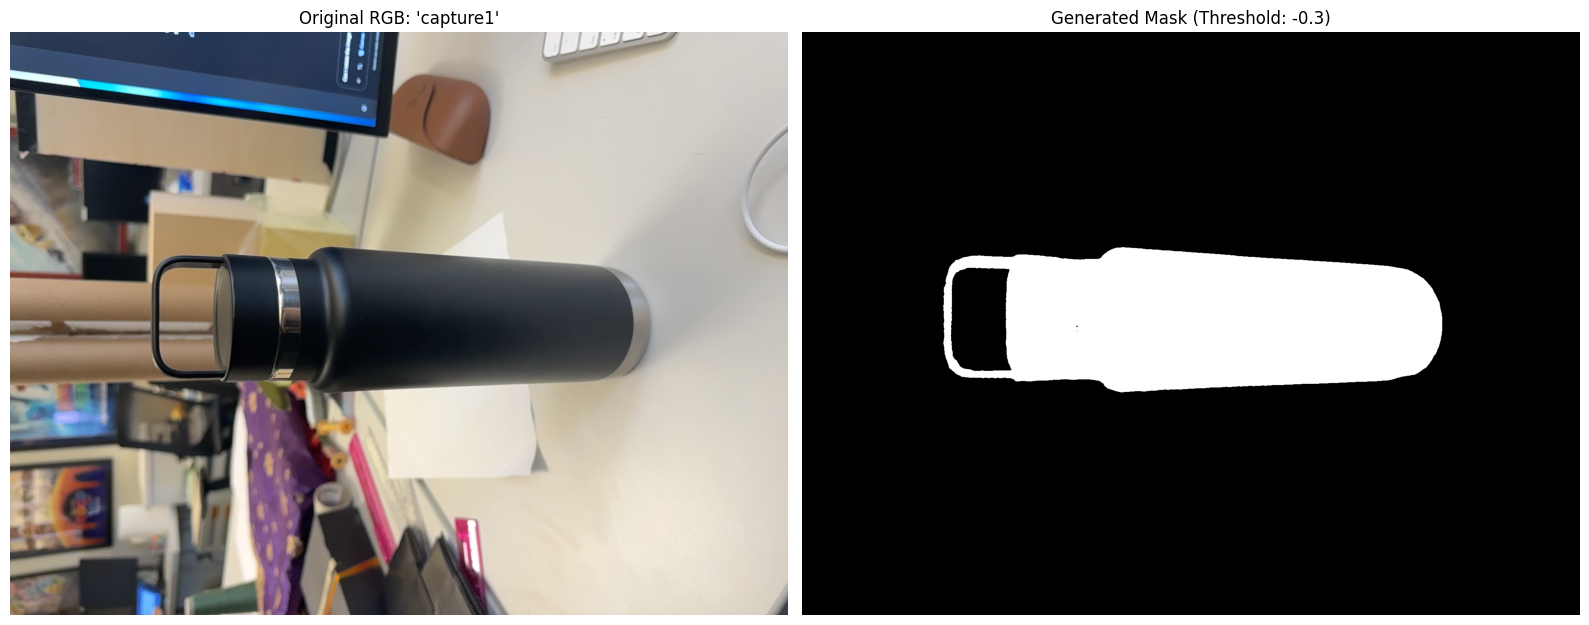

In [11]:
sam_threshold = -0.3
# Apply the threshold
mask_path = segmentation.apply_threshold_to_logits(
    logits_path=logits_path,
    threshold=sam_threshold,
    output_path=results_path
)
print(f"Mask created and saved to: {mask_path}")

# Display
rgb_image = Image.open(rgb_path)
mask_image = Image.open(mask_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(rgb_image)
axes[0].set_title(f"Original RGB: '{VIGNETTE_NAME}'")
axes[0].axis('off')

axes[1].imshow(mask_image, cmap='gray')
axes[1].set_title(f"Generated Mask (Threshold: {sam_threshold})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Step 3: Generate Point Cloud ###

In [5]:
def display_geometries(geometries: list, window_name: str = "Open3D"):
    # Create a Visualizer object
    vis = o3d.visualization.Visualizer()
    # Create the window with a custom name
    vis.create_window(window_name=window_name)
    # Add each geometry to the visualizer
    for geometry in geometries:
        vis.add_geometry(geometry)  
    # Run the visualizer
    vis.run()
    # Destroy it after close
    vis.destroy_window()
    vis.close()
    del vis

In [6]:
# get point cloud
vignette_path = pointcloud.create_masked_point_cloud(VIGNETTE_PATH)

Processing point cloud for: capture1
Generated and centered point cloud with 6028 points.
Saved processed vignette to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1/results/raw_vignette.npz


In [7]:
vignette_path = results_path / "raw_vignette.npz"
 
# Load the points as a processed vignette
from pipeline.vignette_data import ProcessedVignette
vignette = ProcessedVignette.load(vignette_path)

Loaded processed vignette from: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1/results/raw_vignette.npz


In [8]:
# Visualize Colors
pcd_rgb = vignette.to_open3d(color_mode="rgb")
display_geometries([pcd_rgb], window_name="Vignette (RGB Colors)")

Generating Open3D point cloud with 'rgb' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [ ]:
# Visualize Confidence
pcd_confidence = vignette.to_open3d(color_mode="confidence")
display_geometries([pcd_confidence], window_name="Vignette (Confidence Colors)")

Generating Open3D point cloud with 'confidence' colors...


### Step 4: Preprocess Point Cloud ###

In [8]:
from pipeline import preprocessing

processed_vignette = preprocessing.preprocess_vignette(
    raw_vignette=vignette,
    confidence_threshold=1,
    voxel_size=0.001,
    sor_std_ratio=3.0
)

# save it
processed_vignette_path = results_path / "raw_vignette.npz"
processed_vignette.save(processed_vignette_path)

Initial points: 6028
Points after confidence filtering: 5049
Points after downsampling: 5049
Points after outlier removal: 4958
Normals estimated.
Reconciling custom attributes...
Preprocessing complete. Returning new clean vignette.
Saved processed vignette to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1/results/raw_vignette.npz


Generating Open3D point cloud with 'rgb' colors...
Generating Open3D point cloud with 'rgb' colors...


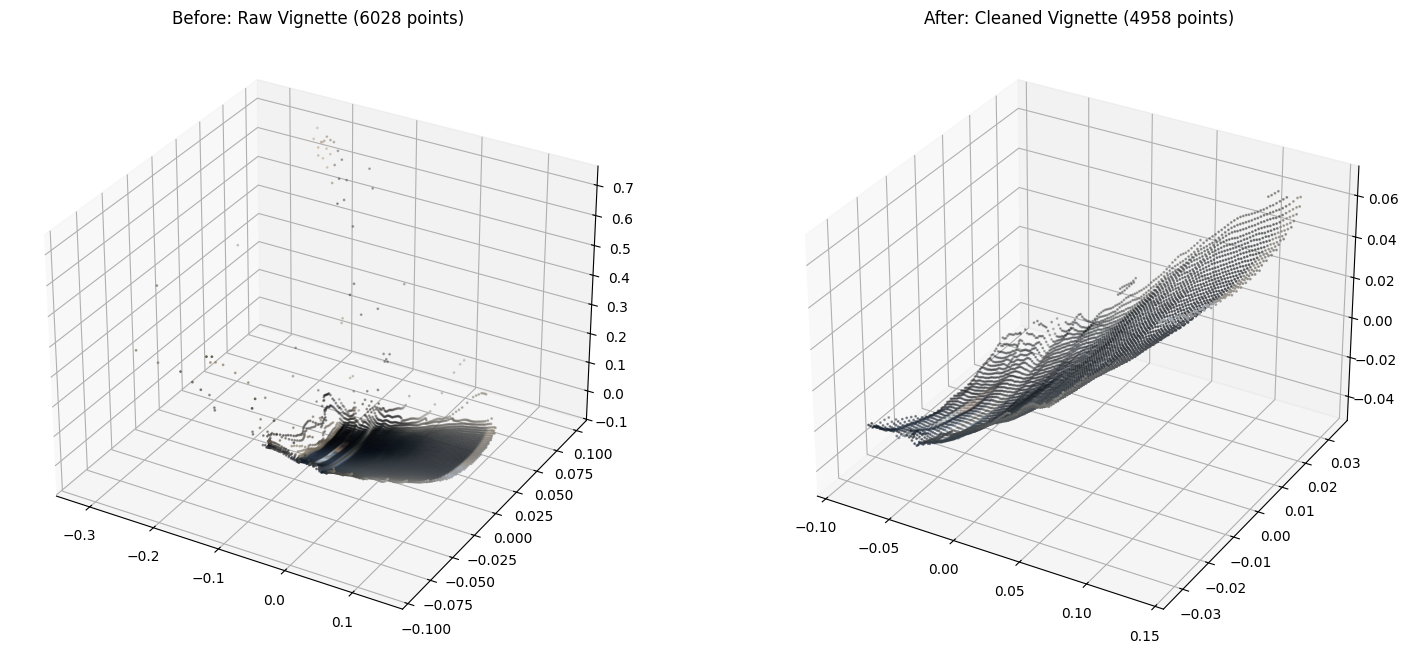

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18, 8))

# Before
ax1 = fig.add_subplot(121, projection='3d')
pcd_raw_viz = vignette.to_open3d().voxel_down_sample(0.001) # Downsample for viz
ax1.scatter(
    np.asarray(pcd_raw_viz.points)[:, 0], np.asarray(pcd_raw_viz.points)[:, 1], np.asarray(pcd_raw_viz.points)[:, 2],
    c=np.asarray(pcd_raw_viz.colors), s=1
)
ax1.set_title(f"Before: Raw Vignette ({len(vignette.points)} points)")
    
# After
ax2 = fig.add_subplot(122, projection='3d')
pcd_clean_viz = processed_vignette.to_open3d()
ax2.scatter(
    np.asarray(pcd_clean_viz.points)[:, 0], np.asarray(pcd_clean_viz.points)[:, 1], np.asarray(pcd_clean_viz.points)[:, 2],
    c=np.asarray(pcd_clean_viz.colors), s=1
)
ax2.set_title(f"After: Cleaned Vignette ({len(processed_vignette.points)} points)")
    
plt.show()

In [10]:
pcd = processed_vignette.to_open3d()
display_geometries([pcd], window_name="Preprocessed Vignette")

Generating Open3D point cloud with 'rgb' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


### Step 5: Abstraction ###

In [ ]:
# TODO - Make them based on ProcessedVignette class & Experiment more methods!

In [ ]:
from pipeline import abstraction

In [14]:
# Dominant Axis
center, axis, extent = abstraction.extract_dominant_axis(pcd)

# Visualize
axis_line = o3d.geometry.LineSet()
axis_line.points = o3d.utility.Vector3dVector([center - axis * extent[0] / 2, center + axis * extent[0] / 2])
axis_line.lines = o3d.utility.Vector2iVector([[0, 1]])
axis_line.colors = o3d.utility.Vector3dVector([[1, 0, 0]])
print("\nVisualizing dominant axis (red line)...")

display_geometries([pcd, axis_line], window_name="Dominant Axis")

Dominant Axis Analysis: Center=[0.02540861 0.00107112 0.00946696], Axis=[ 0.9073511  -0.01243545  0.42018964], Extent=[0.24444651 0.06653642 0.02993881]

Visualizing dominant axis (red line)...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [15]:
# --- 5b. Visualize Dominant Planes ---
planes = abstraction.extract_dominant_planes(pcd, distance_threshold=0.01)
    
plane_geometries = [pcd.paint_uniform_color([0.7, 0.7, 0.7])] # Start with the original pcd in gray
colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1]] # Different colors for each plane
    
for i, (eq, plane_pcd) in enumerate(planes):
    # Color each plane with a different color
    plane_pcd.paint_uniform_color(colors[i % len(colors)])
    plane_geometries.append(plane_pcd)
        
print("\nVisualizing dominant planes (in color)...")
display_geometries(plane_geometries, window_name="Dominant Planes")
    


Found plane with 4701 points. 257 points remaining.
Found plane with 257 points. 0 points remaining.

Visualizing dominant planes (in color)...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [16]:
# Visualize Abstract Mesh
abstract_mesh = abstraction.create_abstract_mesh(pcd, alpha=0.03)
    
print("\nVisualizing abstract mesh with original points...")
display_geometries([pcd, abstract_mesh], window_name="Abstract Mesh")

Creating Alpha Shape mesh with alpha=0.03...
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
Generated mesh with 6960 triangles.

Visualizing abstract mesh with original points...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized
